In [2]:
import scanpy as sc
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [3]:
import sys
sys.path.insert(0, "../lib")

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
import script.scanpy as sc_utils

In [5]:
mpl.rcParams["figure.figsize"] = (16, 12)
pd.set_option('display.max_rows', 1000)

## Load Habermann

In [14]:
habermann = sc.read_10x_mtx("../data/05il6/habermann/")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [15]:
habermann_meta = pd.read_csv("../data/05il6/habermann/metadata.csv", index_col=0)

In [19]:
habermann = habermann[habermann.obs_names.isin(habermann_meta.index), :]

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [20]:
habermann.obs = habermann_meta.loc[habermann.obs_names, :]

In [22]:
habermann.write_h5ad("../data/05il6/habermann/habermann.h5ad")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'orig.ident' as categorical
... storing 'Diagnosis' as categorical
... storing 'Sample_Name' as categorical
... storing 'Sample_Source' as categorical
... storing 'Status' as categorical
... storing 'population' as categorical
... storing 'celltype' as categorical
... storing 'feature_types' as categorical


In [160]:
habermann.obs_names

Index(['F01157_AAACCTGAGCATCATC', 'F01157_AAACCTGTCATGCTCC',
       'F01157_AAACGGGGTTACGACT', 'F01157_AAACGGGGTTAGTGGG',
       'F01157_AAACGGGTCCTTTCGG', 'F01157_AAAGATGGTACCGAGA',
       'F01157_AAAGATGTCAGCGATT', 'F01157_AAAGCAAAGCCAGAAC',
       'F01157_AAAGCAAAGGACGAAA', 'F01157_AAAGCAAAGTATTGGA',
       ...
       'F01392_TTTGCGCGTGCTTCTC', 'F01392_TTTGCGCTCACTCCTG',
       'F01392_TTTGGTTCAACTGCTA', 'F01392_TTTGGTTCATTCCTCG',
       'F01392_TTTGGTTTCCCTCTTT', 'F01392_TTTGGTTTCTCTTGAT',
       'F01392_TTTGTCACACCCAGTG', 'F01392_TTTGTCACAGATGGGT',
       'F01392_TTTGTCATCTCATTCA', 'F01392_TTTGTCATCTTGTACT'],
      dtype='object', length=114396)

## Load Liao

In [42]:
def rename_genes(names):
    names = names.str.replace("^GRCh38_+", "")
    names = names.str.replace("^SARS-CoV-2i_", "SARS-CoV-2-")
    names = names.str.replace("SARS-CoV-2-antisense", "Antisense")
    return names

In [26]:
liao_meta = pd.read_csv("../data/05il6/liao-et-al/metadata.tsv", sep="\t", index_col=0)

In [31]:
liao_meta.groupby("sample").head(1)

,sample,sample_new,group,disease,hasnCoV,cluster,celltype
ID,,,,,,,
AAACCTGAGACACTAA_1,C51,HC1,HC,N,N,3,Macrophages
AAACCTGAGATATACG_2,C52,HC2,HC,N,N,3,Macrophages
AAACCCACAGCTACAT_3,C100,HC3,HC,N,N,27,B
AAACCTGCAGCATGAG_4,GSM3660650,HC4,HC,N,N,6,T
AAACCTGAGATGTCGG_5,C141,M1,M,Y,N,6,T
AAACCTGAGTGAACGC_6,C142,M2,M,Y,N,6,T
AAACGGGTCGAATGCT_7,C144,M3,M,Y,N,20,mDC
AAACCTGAGACTTTCG_8,C143,S2,S,Y,N,4,Macrophages
AAACCTGAGCCCGAAA_9,C145,S1,S,Y,N,15,Neutrophil


In [65]:
samples = []
for s in os.listdir("../data/05il6/liao-et-al/"):
    if not os.path.isdir(f"../data/05il6/liao-et-al/{s}"):
        continue
    num = liao_meta.index[liao_meta["sample"] == s][0].split("_")[1]
    ds = sc.read_10x_mtx(f"../data/05il6/liao-et-al/{s}/")
    ds.var_names = rename_genes(ds.var_names)
    ds.var_names_make_unique(join=".")
    ds.obs_names = ds.obs_names.str.replace("-\d+$", "") + f"_{num}"
    samples.append(ds)

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [66]:
liao = samples[0].concatenate(samples[1:])

In [67]:
liao.obs_names = liao.obs_names.str.replace("-\d+$", "")

In [68]:
liao_meta.index.isin(liao.obs_names).sum()

42272

Check missing cells

In [74]:
liao_meta["sample"][~liao_meta.index.isin(liao.obs_names)].value_counts()

C51           8454
C52           8153
GSM3660650    2710
C100          2566
C143           899
C145           422
C152           152
C148            55
C149            51
C142            40
C141            30
C146             9
Name: sample, dtype: int64

In [76]:
liao_cells = liao.obs_names[liao.obs_names.isin(liao_meta.index)]
liao = liao[liao.obs_names.isin(liao_cells), :]
liao.obs = liao_meta.loc[liao_cells, :]

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [78]:
liao.write_h5ad("../data/05il6/liao-et-al/liao.h5ad")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'sample_new' as categorical
... storing 'group' as categorical
... storing 'disease' as categorical
... storing 'hasnCoV' as categorical
... storing 'celltype' as categorical
... storing 'feature_types' as categorical


## Load Grant

In [21]:
grant = sc.read_h5ad("../data/04dataset/04obj-manual.h5ad")

In [22]:
grant = grant.raw.to_adata()

## Merge

First merge Habermann and Liao, they have raw counts

In [23]:
total = habermann.concatenate([liao])

/projects/b1038/Pulmonary/nmarkov/script/code/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/projects/b1038/Pulmonary/nmarkov/script/code/.venv/lib/python3.6/site-packages/anndata/_core/merge.py:461: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat([a.obs for a in adatas], ignore_index=True)


In [24]:
total.obs_names = total.obs_names.str.replace("-\d+$", "")

In [25]:
sc.pp.normalize_total(total, target_sum=1e4)
sc.pp.log1p(total)

Then add Grant, as counts are already normalized

In [26]:
total = total.concatenate([grant])

/projects/b1038/Pulmonary/nmarkov/script/code/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/projects/b1038/Pulmonary/nmarkov/script/code/.venv/lib/python3.6/site-packages/anndata/_core/merge.py:461: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat([a.obs for a in adatas], ignore_index=True)


In [27]:
total.obs_names = total.obs_names.str.replace("-\d+$", "")

In [28]:
total.obs["study"] = ""
total.obs.loc[grant.obs.index, "study"] = "G"
total.obs.loc[habermann.obs.index, "study"] = "H"
total.obs.loc[liao.obs.index, "study"] = "L"

In [29]:
total.obs.celltype = total.obs.celltype.astype(str)
total.obs.celltype = "(" + total.obs.study + ".) " + total.obs.celltype
total.obs.celltype = total.obs.celltype.astype("category")

In [30]:
total.obs.celltype.value_counts(dropna=False)

(H.) Macrophages                       38928
(L.) Macrophages                       29604
(G.) TRAM1                             26911
(H.) Ciliated                          14671
(G.) MoAM3                             12535
(G.) MoAM2                             12054
(G.) MoAM4                             11839
(H.) AT2                                9311
(H.) Endothelial Cells                  9243
(H.) Monocytes                          6765
(H.) T Cells                            6703
(L.) T                                  6485
(G.) CD4 CM T cells                     5883
(G.) Plasma cells                       5757
(G.) CD8 cytotoxic T cells              5237
(G.) MoAM1                              4656
(G.) CD8 cytotoxic TRM T cells          3532
(H.) SCGB3A2+                           3220
(G.) TRAM2                              2450
(H.) MUC5B+                             2433
(H.) NK Cells                           2322
(H.) cDCs                               2132
(L.) Epith

In [31]:
cd4_il6 = total[total.obs.celltype == "(G.) CD4 CM T cells", total.var_names == "IL6"].X.todense().A.reshape(-1)

In [32]:
pd.Series(cd4_il6).describe()

count    5883.000000
mean        0.000279
std         0.021411
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.642228
dtype: float64

In [33]:
end_il6 = total[total.obs.celltype == "(H.) Endothelial Cells", total.var_names == "IL6"].X.todense().A.reshape(-1)

In [34]:
pd.Series(end_il6).describe()

count    9243.000000
mean        0.303196
std         0.762369
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.461442
dtype: float64

... storing 'COVID-19' as categorical
... storing 'Diagnosis' as categorical
... storing 'Sample_Name' as categorical
... storing 'Sample_Source' as categorical
... storing 'Status' as categorical
... storing 'cluster' as categorical
... storing 'disease' as categorical
... storing 'group' as categorical
... storing 'hasnCoV' as categorical
... storing 'leiden' as categorical
... storing 'orig.ident' as categorical
... storing 'patient' as categorical
... storing 'population' as categorical
... storing 'sample' as categorical
... storing 'sample_new' as categorical
... storing 'sample_status' as categorical
... storing 'type' as categorical
... storing 'study' as categorical


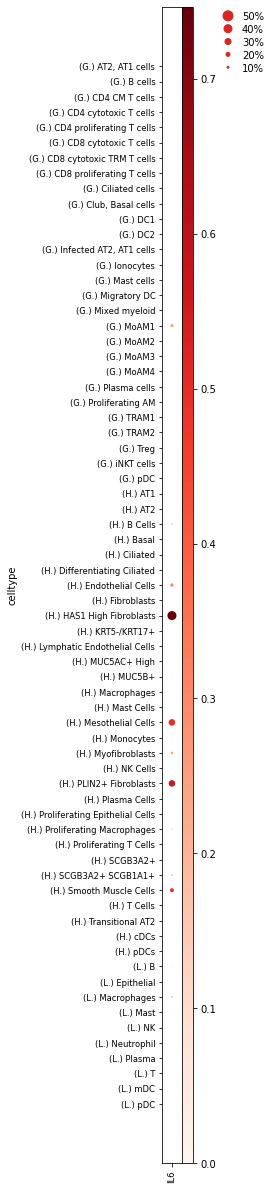

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.35, 0, 0.2, 0.5, 0.25])

In [35]:
sc.pl.dotplot(total, "IL6", 'celltype', save="01il6-dotplot.pdf")

In [36]:
total.write_h5ad("../data/05il6/total.h5ad")

In [11]:
total = sc.read_h5ad("../data/05il6/total.h5ad")

## Split Habermann cells into Healthy and Fibrosis

In [76]:
total.obs["plot_group"] = ""

In [77]:
total.obs.Status.value_counts()

nan        147987
Disease     82752
Control     31644
Name: Status, dtype: int64

In [78]:
total.obs.loc[total.obs.Status == "Disease", "plot_group"] = "(H.) Fibrosis"

In [79]:
total.obs.loc[total.obs.Status == "Control", "plot_group"] = "(H.) Control"

In [80]:
total.obs.group.value_counts()

nan    220111
S       35031
M        7241
Name: group, dtype: int64

In [81]:
total.obs.loc[total.obs.group == "S", "plot_group"] = "(L.) Severe COVID-19"

In [82]:
total.obs.loc[total.obs.group == "M", "plot_group"] = "(L.) Mild COVID-19"

In [83]:
total.obs.loc[total.obs.patient != "nan", "plot_group"] = "(G.) Patient " + total.obs.patient.astype(str)

In [85]:
total.obs.plot_group = total.obs.plot_group.astype("category")

In [86]:
il6expr = total[:, total.var_names == "IL6"].X.todense().A.reshape(-1)

(array([2.52955e+05, 3.17600e+03, 2.89400e+03, 1.68200e+03, 8.95000e+02,
        4.33000e+02, 2.02000e+02, 9.80000e+01, 4.10000e+01, 7.00000e+00]),
 array([0.       , 0.5461441, 1.0922883, 1.6384325, 2.1845765, 2.7307208,
        3.276865 , 3.823009 , 4.369153 , 4.9152975, 5.4614415],
       dtype=float32),
 <a list of 10 Patch objects>)

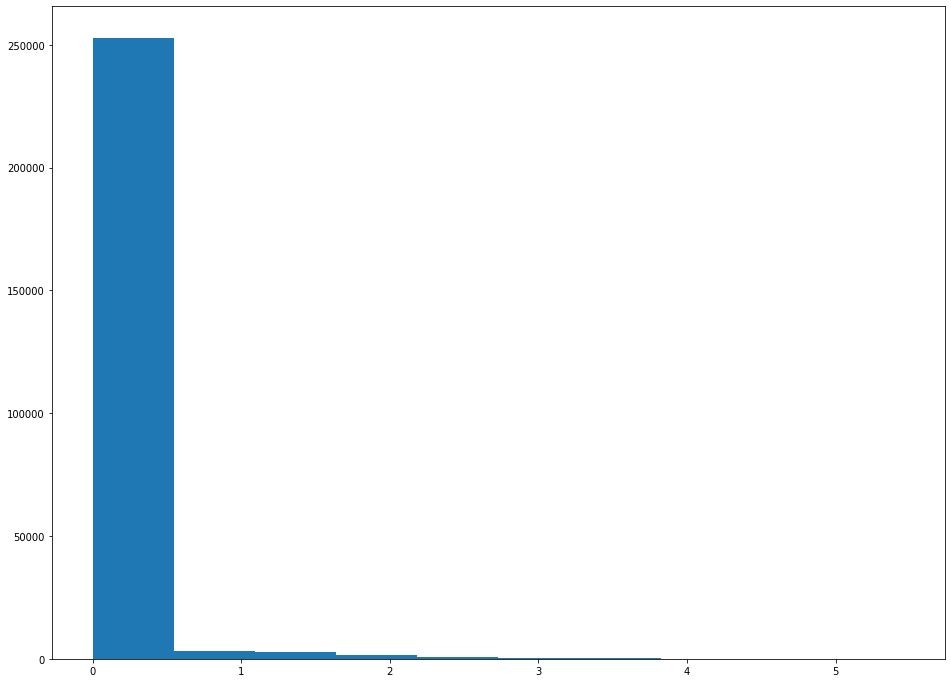

In [87]:
plt.hist(il6expr)

## Plot

In [88]:
total.obs.plot_group.value_counts()

(H.) Fibrosis           82752
(L.) Severe COVID-19    35031
(H.) Control            31644
(G.) Patient C          17961
(G.) Patient 8          16099
(G.) Patient A          15373
(G.) Patient 6          10608
(G.) Patient 9          10374
(G.) Patient 3           9353
(L.) Mild COVID-19       7241
(G.) Patient 1           7060
(G.) Patient B           4956
(G.) Patient 7           4887
(G.) Patient 5           3909
(G.) Patient 4           2756
(G.) Patient 2           2379
Name: plot_group, dtype: int64

In [91]:
plot_group_order = list(sorted(
    total.obs.plot_group.cat.categories,
    key=lambda x: x.replace("H.", "X.")
))

In [92]:
total.obs.celltype.value_counts().sort_index()

(G.) AT2, AT1 cells                      260
(G.) B cells                             644
(G.) CD4 CM T cells                     5883
(G.) CD4 cytotoxic T cells              1882
(G.) CD4 proliferating T cells          1007
(G.) CD8 cytotoxic T cells              5237
(G.) CD8 cytotoxic TRM T cells          3532
(G.) CD8 proliferating T cells          1178
(G.) Ciliated cells                     1493
(G.) Club, Basal cells                   394
(G.) DC1                                 890
(G.) DC2                                 824
(G.) Infected AT2, AT1 cells              74
(G.) Ionocytes                            54
(G.) Mast cells                           37
(G.) Migratory DC                        903
(G.) Mixed myeloid                      1604
(G.) MoAM1                              4656
(G.) MoAM2                             12054
(G.) MoAM3                             12535
(G.) MoAM4                             11839
(G.) Plasma cells                       5757
(G.) Proli

In [93]:
keep_celltypes = [
    "(H.) B Cells", "(H.) Endothelial Cells", "(H.) Fibroblasts", "(H.) HAS1 High Fibroblasts",
    "(H.) Lymphatic Endothelial Cells", "(H.) Macrophages", "(H.) Mesothelial Cells", 
    "(H.) Myofibroblasts", "(H.) PLIN2+ Fibroblasts", "(H.) Proliferating Macrophages",
    "(H.) SCGB3A2+ SCGB1A1+", "(H.) Smooth Muscle Cells", "(L.) Macrophages", "(L.) Neutrophil"
]

In [94]:
clusters = total.obs.celltype.astype("category").cat.categories
clusters = clusters[clusters.str.startswith("(G") | clusters.isin(keep_celltypes)]

In [95]:
clusters_order = list(sorted(
    clusters, 
    key=lambda x: x.replace("H.", "X.")\
        .replace("Infected ", "").replace("Plasma", "BP")\
        .replace("Treg", "CD9").replace("iNKT", "CD99")\
        .replace("pDC", "DC3").replace("Io", "Cluz")
))

In [96]:
il6_mask = total.var_names == "IL6"
il6_mean_rows = []
for i, p in enumerate(plot_group_order):
    for j, c in enumerate(clusters_order):
        expr = il6expr[(total.obs.celltype == c) & (total.obs.plot_group == p)]
        pct = np.sum(expr > 0) / (total.obs.celltype == c).sum()
        mean = np.mean(expr)
        il6_mean_rows.append((i, j, p, c, mean, pct, expr.shape[0]))

/projects/b1038/Pulmonary/nmarkov/script/code/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/projects/b1038/Pulmonary/nmarkov/script/code/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [97]:
il6_df = pd.DataFrame(il6_mean_rows, columns=["idx_p", "idx_c", "patient", "cluster", "mean_expr", "pct", "count"])

In [98]:
il6_df.fillna(0, inplace=True)

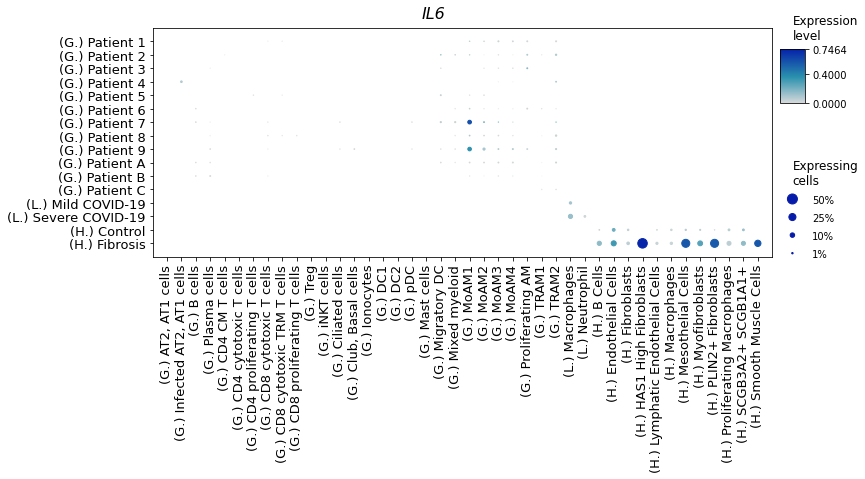

In [100]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(2, 2, figure=fig, width_ratios=(39, 1), wspace=0.05, hspace=0.1)
ax1 = fig.add_subplot(gs[:, 0])
cax = fig.add_subplot(gs[0, 1])
sax = fig.add_subplot(gs[1, 1])
x = ax1.scatter(
    il6_df.idx_c, 
    il6_df.idx_p * -1, 
    s=il6_df.pct * 200, 
    c=il6_df.mean_expr, 
    cmap=sc_utils.expr_colormap()
)
fig.subplots_adjust(bottom=0.45)
fig.colorbar(x, cax=cax, ticks=[0, 0.4, il6_df.mean_expr.max()])
cax.set_title("Expression\nlevel", ha="left", pad=10)
cax_p = cax.get_position()
cax_p.y0 += 0.08
cax_p.x0 += 0.02
cax_p.x1 += 0.03
cax.set_position(cax_p)

ax1.set_yticks(range(0, -total.obs.plot_group.unique().size, -1))
ax1.set_yticklabels(plot_group_order, fontsize=13)
ax1.set_ylim(-total.obs.plot_group.unique().size, 1)
ax1.set_xlim(-1, clusters.size)
ax1.set_xticks(range(clusters.size))
ax1.set_xticklabels(clusters_order, rotation=90, fontsize=13)
ax1_p = ax1.get_position()
ax1_p.x0 += 0.05
ax1_p.x1 += 0.03
ax1_p.y0 -= 0.05
ax1_p.y1 += 0.05
ax1.set_position(ax1_p)
trans = mpl.transforms.Affine2D().translate(6, 0)
# for t in ax1.get_xticklabels():
#     t.set_transform(t.get_transform() + trans)

sax.scatter(
    [0, 0, 0, 0],
    [0, 1, 2, 3],
    np.array([0.01, 0.1, 0.25, 0.5]) * 200,
    c=[[6/256, 27/256, 170/256]]*4
)
sax.set_ylim(-0.2, 3.5)
sax.tick_params(left=False, labelleft=False, labelright=True, bottom=False, labelbottom=False)
sax.set_yticks([0, 1, 2, 3])
sax.set_yticklabels(["1%", "10%", "25%", "50%"])
sax.set_title("Expressing\ncells", ha="left")
for x in sax.spines.keys():
    sax.spines[x].set_visible(False)
sax_p = sax.get_position()
sax_p.y0 -= 0.05
sax_p.y1 -= 0.1
sax_p.x0 += 0.02
sax_p.x1 += 0.03
sax.set_position(sax_p)
fig.suptitle("IL6", fontsize=16, fontstyle="italic")
fig.savefig("S6A_il6_dot.pdf")